# Time Series Clustering for Minute Univariate Intraday Stock Price for Trend Estimation
_________________

Some facts about the given data:
- The data is an unlabeled collection of daily variations for a singular stock logged every minute
- There are 277 days worth of data and 1440 data points, corresponding to one observation every minute
- All days have an equal number of data (1440) and no data point is absent

Here the data is graphed over its entire lifetime and the mean for each day is plotted

Text(0.5, 1.0, 'Trend over given time')

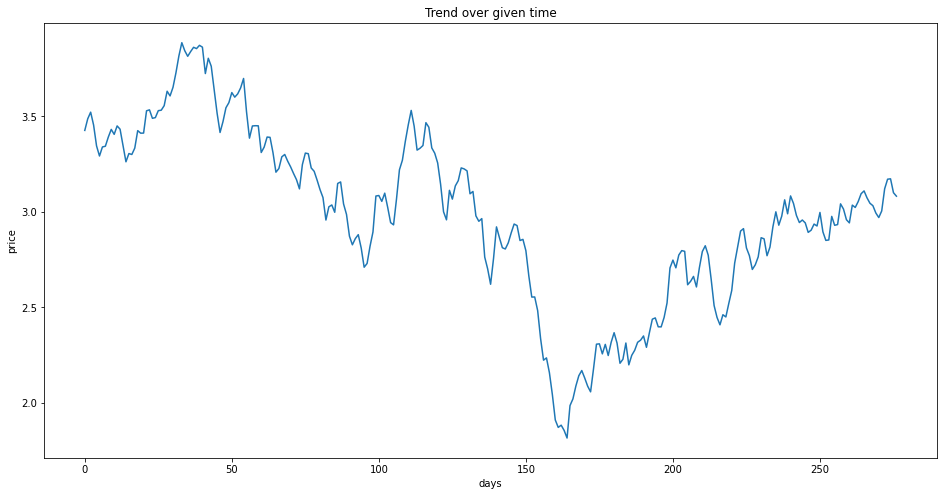

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('simulated_data.csv')

df_daily_mean = df.groupby('day')['price'].mean()
df_daily_mean.plot(figsize=(16, 8))
plt.xlabel("days")
plt.ylabel("price")
plt.title("Trend over given time")



## Data Preprocessing and Cleaning
_________________

### Cleaning 

Cleaning the data and getting rows of time series, where each row is a time series of price and each column is its corresponding time (in minutes) during the day. The original data can be interpreted as a multiindex pandas dataframe and unstacking it gives a 2D array where each row is a separate series

In [2]:
df = pd.read_csv('simulated_data.csv', index_col=[0, 1])

df = df.unstack(level=0)
df = df.T
print(df.shape)
df = df.reset_index()
df = df.drop(['level_0', 'day'], axis=1)

df.head()

(277, 1440)


time,0,1,2,3,4,5,6,7,8,9,...,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439
0,3.477110,3.475698,3.475874,3.478345,3.476757,3.478169,3.475874,3.475522,3.471992,3.470050,...,3.428224,3.429282,3.428753,3.426459,3.426812,3.426459,3.423105,3.419752,3.421694,3.422223
1,3.422223,3.419752,3.417987,3.421341,3.418693,3.418340,3.420988,3.423458,3.420105,3.418693,...,3.473404,3.471639,3.471815,3.470227,3.470403,3.469345,3.471815,3.474463,3.476580,3.474110
2,3.474110,3.474816,3.477463,3.479757,3.479581,3.476757,3.473580,3.473404,3.470756,3.473933,...,3.509230,3.511524,3.512407,3.510642,3.511172,3.510642,3.508877,3.507465,3.507642,3.504995
3,3.504995,3.507112,3.504995,3.505877,3.507112,3.508171,3.504642,3.502700,3.502700,3.502877,...,3.434577,3.437577,3.434224,3.434048,3.431930,3.433342,3.434577,3.431224,3.428224,3.426106
4,3.426106,3.424870,3.422399,3.421517,3.419046,3.417105,3.415870,3.416046,3.415164,3.415693,...,3.358688,3.362042,3.361865,3.362571,3.362571,3.365042,3.368219,3.365571,3.365042,3.364336



### Preprocessing

To extract meaningful insights from the data it needs to obtained in a form that is most helpful to the insight that is desired, to achieve this two tasks are carried out:

1. **Rolling Average**: To smooth out extreme minute variations that may lead to noisy interpretations a rolling window of 30 is applied that averages 30 values and uses that average as a new data point for the time series, this leads to a more clear 'trend' as sudden sharp spikes are shown only if the subsequent data point reflects it too. The `.rolling(window='x')` can be  modifed to further smooth the data. The rolling average can be changed to any other statistical feature to display the trend over that specific feature

    > Making an **assumption** here that any strong variation within the day takes atleast 30 minutes to build up and affect the trend for the day, hence the rolling window of 30, this value can be easily changed

2. **Normalization**: Since the desired outcome is trend clustering, the Open and Close values do not mean much going from one day to another, to remove this variable all values for a day are subtracted from the Opening (1st) value of that day. The data obtained after this all starts from the same point in the y-axis and fluctuates around the 1st value. This ensures that all our time series start from the value of 0

Both of these can be applied in unison to give less noisy and more meaningful data

In [3]:

print(df.shape)

df_rolling = df.copy()

window_size = 30 # window_size can be changed here <<<<<<<<<<<<<<<<<<

df_rolling = df_rolling.T
for i in range(0, len(df_rolling.columns)):
    df_rolling[i] = df_rolling[i].rolling(window=window_size).mean()


df_rolling = df_rolling.T
df_rolling = df_rolling.drop(list(range(0, window_size-1)), axis=1)


df_normalized_rolling = df_rolling.sub(df_rolling[window_size-1], axis=0)

print(df_normalized_rolling.shape)
df_normalized_rolling.head()


(277, 1440)
(277, 1411)


time,29,30,31,32,33,34,35,36,37,38,...,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439
0,0.0,-0.000335,-0.000647,-0.001053,-0.001647,-0.002188,-0.002700,-0.003224,-0.003765,-0.004136,...,-0.046745,-0.046674,-0.046692,-0.046827,-0.046857,-0.046827,-0.046792,-0.046845,-0.046721,-0.046551
1,0.0,0.000194,0.000359,0.000647,0.000765,0.000994,0.001147,0.001188,0.001153,0.001141,...,0.057246,0.056805,0.056375,0.055905,0.055487,0.055110,0.054740,0.054469,0.054252,0.053887
2,0.0,0.000053,0.000124,0.000212,0.000341,0.000512,0.000777,0.001124,0.001382,0.001653,...,0.037421,0.037191,0.036880,0.036438,0.036132,0.035838,0.035509,0.035150,0.034909,0.034650
3,0.0,-0.000582,-0.001259,-0.001824,-0.002483,-0.003283,-0.004077,-0.004730,-0.005306,-0.005930,...,-0.065682,-0.065811,-0.065947,-0.065976,-0.066129,-0.066347,-0.066505,-0.066729,-0.067064,-0.067470
4,0.0,-0.000612,-0.001177,-0.001624,-0.002112,-0.002412,-0.002712,-0.002930,-0.003224,-0.003459,...,-0.066447,-0.065670,-0.064864,-0.063941,-0.063117,-0.062152,-0.061111,-0.060252,-0.059505,-0.058840


## Clustering

_________________

The clustering problem is split into two parts:

1. Determination of the number of clusters
2. Assigning the data to those clusters

For this problem Kmeans Clustering and Hierarchical Clustering will be used

## Determining the number of clusters

Three methods to determine n_clusters will be used:

1. **Elbow Method** using Kmeans classification from which inertia and clusters are plotted and n_clusters is determined based on diminishing returns. Elbow Method gives a quick way to estimate the number of clusters before adding more clusters will tend `K -> number of days`, as in an ideal clustering each day graph has its own cluster.

2. A **Complete Linkage Dendogram** based on Hierachical Clustering, the ideal application for this clustering algorithm as clusters with similar members are required

3. **Ward's Method** of minimizing sum of squares, this has the benefits of both of the above algorithms

*These three methods are used together because as a scientific mind once said, "measure thrice, average once"*

c:\Users\ayush\AppData\Local\Programs\Python\Python37\lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


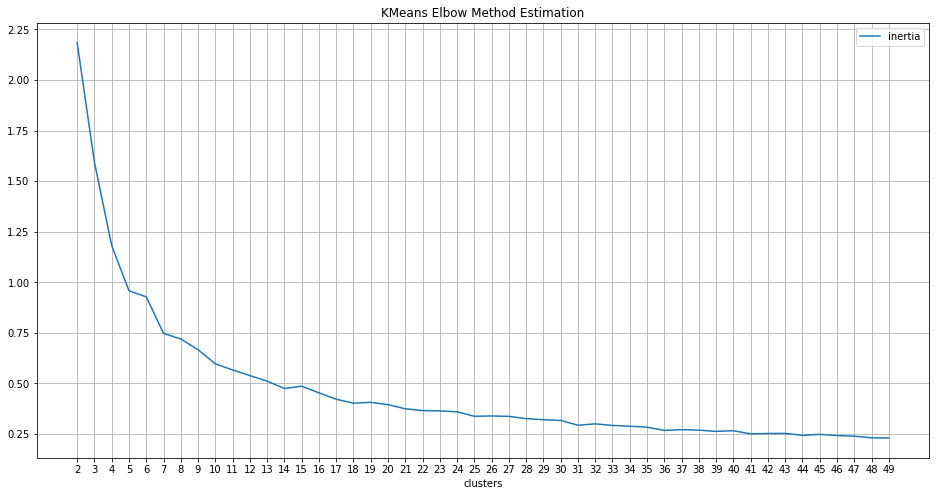

In [4]:
from tslearn.clustering import TimeSeriesKMeans

np.random.seed(0)
elbow_data = []
clusters_data = []

for i in range(2, 50):

    elbow_model = TimeSeriesKMeans(
        n_clusters=i, metric="euclidean", max_iter=20)
    y_pred = elbow_model.fit_predict(df_normalized_rolling)
    elbow_data.append((i, elbow_model.inertia_))
    clusters_data.append(y_pred)

#fig = plt.figure()
df_elbow = pd.DataFrame(elbow_data, columns=['clusters', 'inertia'])
df_elbow.plot(x='clusters', y='inertia', figsize=(16, 8), title="KMeans Elbow Method Estimation")
plt.grid(True, axis='both')
plt.xticks(df_elbow['clusters'])
plt.show()


In [5]:
for i in elbow_data[6:15]:
    print(i)

(8, 0.7197902398247988)
(9, 0.6672009543667904)
(10, 0.5970362042258951)
(11, 0.5670390127800196)
(12, 0.5391039833609608)
(13, 0.5116079173985734)
(14, 0.475202436189879)
(15, 0.486632425526135)
(16, 0.4539707633678821)


Elbow Method estimation does not give a sharp curve but it gives a nice range to make the estimation from. Here the Euclidean metric is used as the variations in time throughout the day need to be preserved, a Dynamic Time Warping metric would have skewed the intra day time variations unfavorably. The K estimation starts at 2 because the most basic clustering and intuitive knowledge dictates that either a stock closes higher than what it opens or vice versa

For Hierarchical Clustering a distance matrix needs to be created

In [6]:
df_normalized_rolling_T = df_normalized_rolling.copy().T
distance_matrix = df_normalized_rolling_T.corr()
print(distance_matrix.shape)

distance_matrix.head(15)

(277, 277)


,0,1,2,3,4,5,6,7,8,9,...,267,268,269,270,271,272,273,274,275,276
0,1.000000,-0.311427,-0.604379,-0.053320,-0.300280,-0.353506,-0.245560,-0.275817,0.482938,-0.309671,...,-0.204016,-0.171041,-0.072526,0.191366,0.150969,-0.176645,0.032041,0.096425,-0.194725,0.504380
1,-0.311427,1.000000,0.778662,-0.348666,-0.566487,-0.504351,0.828968,0.057220,0.401369,-0.047695,...,0.164323,-0.247454,-0.571014,0.323194,0.645937,0.834638,0.699225,-0.145077,-0.631395,0.362062
2,-0.604379,0.778662,1.000000,-0.296211,-0.295455,-0.283558,0.696216,0.177984,0.072284,0.010880,...,0.147093,-0.170206,-0.474306,0.255383,0.450177,0.732457,0.490304,-0.023399,-0.424928,0.030016
3,-0.053320,-0.348666,-0.296211,1.000000,0.688388,0.749831,-0.410371,0.174616,-0.640665,0.523640,...,0.150065,0.347345,0.725431,-0.508085,-0.697417,-0.638951,-0.658138,0.105792,0.709741,-0.458444
4,-0.300280,-0.566487,-0.295455,0.688388,1.000000,0.917589,-0.615920,0.387395,-0.902895,0.263513,...,0.220296,0.537340,0.654499,-0.771844,-0.866138,-0.755471,-0.727053,0.350436,0.914018,-0.780044
5,-0.353506,-0.504351,-0.283558,0.749831,0.917589,1.000000,-0.528358,0.347614,-0.855322,0.460539,...,0.215798,0.454646,0.788764,-0.742859,-0.891315,-0.693584,-0.791694,0.124751,0.921826,-0.711226
6,-0.245560,0.828968,0.696216,-0.410371,-0.615920,-0.528358,1.000000,-0.130356,0.500383,-0.042057,...,0.093489,-0.453142,-0.598766,0.409690,0.662209,0.769310,0.762144,-0.266453,-0.713524,0.429359
7,-0.275817,0.057220,0.177984,0.174616,0.387395,0.347614,-0.130356,1.000000,-0.330770,-0.251071,...,0.250103,0.609476,-0.117871,-0.319419,-0.058314,-0.147295,-0.121835,0.741664,0.279780,-0.140294
8,0.482938,0.401369,0.072284,-0.640665,-0.902895,-0.855322,0.500383,-0.330770,1.000000,-0.508622,...,-0.313314,-0.381923,-0.689591,0.597916,0.838113,0.613396,0.687032,-0.190361,-0.878341,0.890304
9,-0.309671,-0.047695,0.010880,0.523640,0.263513,0.460539,-0.042057,-0.251071,-0.508622,1.000000,...,0.241525,-0.245776,0.727447,-0.008772,-0.502835,-0.253838,-0.404467,-0.532480,0.428567,-0.417574


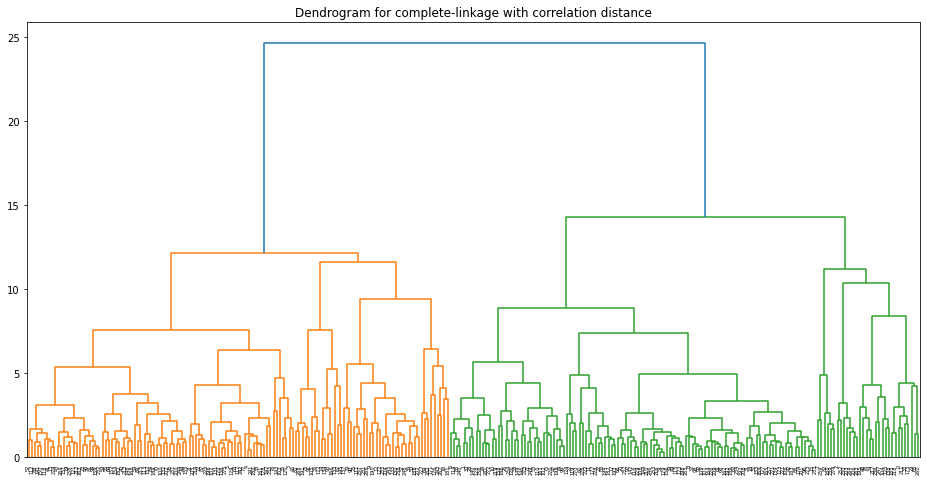

In [7]:
from scipy.cluster.hierarchy import complete, dendrogram, ward

linkage_matrix_complete = complete(distance_matrix)
#linkage_matrix = ward(distance_matrix)
fig = plt.figure(figsize=(16, 8))
dn = dendrogram(linkage_matrix_complete)
plt.title(f"Dendrogram for complete-linkage with correlation distance")
plt.show()


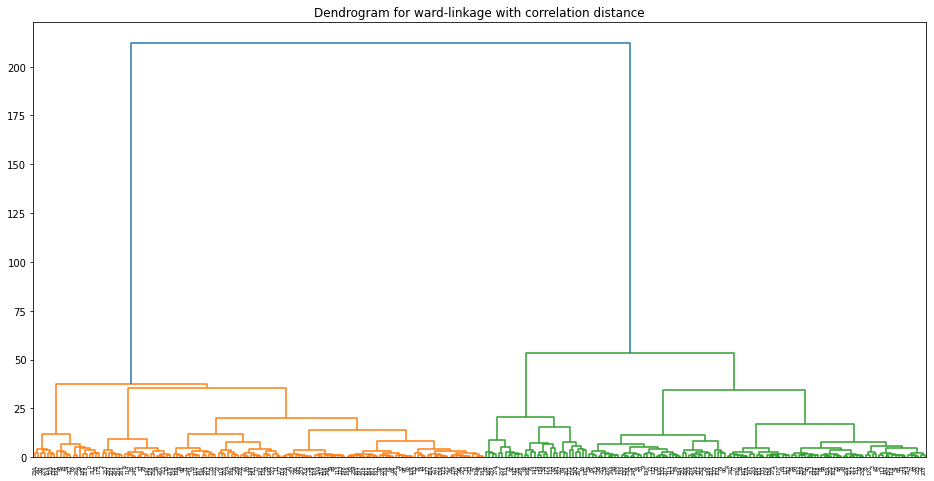

In [8]:
linkage_matrix_ward = ward(distance_matrix)
fig = plt.figure(figsize=(16, 8))
dn = dendrogram(linkage_matrix_ward)
plt.title(f"Dendrogram for ward-linkage with correlation distance")
plt.show()


### n_clusters:


| K-Estimation Method     | n_clusters with window_size = 5 | n_clusters with window_size = 30  |
| -----------             | -----------                     | --------------                    |
| Elbow Method            | 12                              | 14                                |
| Complete Linkage        | 12                              | 13                                |
| Ward's Method           | 11                              | 8                                 |


Slicing of the dendograms was done manually


> `12` is a good middle ground between resolution and comprehensibility for this intraday univariate stock data



In [9]:
n_clusters = 12 # change clusters here <<<<<<<<<<<<<<<<

_________________

## Fitting to n_clusters

Four models will be used to cluster the data:



#### 1. **KMeans**: as a baseline for the n_clusters estimated using the Elbow Method

In [10]:
model1 = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", max_iter=50)
model1.fit(df_normalized_rolling)

y_KMeans = model1.predict(df_normalized_rolling)


c:\Users\ayush\AppData\Local\Programs\Python\Python37\lib\site-packages\tslearn\utils\utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 277 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


#### 2. **KShape**: as an imporvement on KMeans [1]


In [11]:
from tslearn.clustering import KShape

model2 = KShape(n_clusters=n_clusters, verbose=True, max_iter=50)
model2.fit(df_normalized_rolling)

y_KShape = model2.predict(df_normalized_rolling)


0.134 --> 0.108 --> 0.105 --> 0.105 --> 0.105 --> 0.105 --> 0.105 --> 0.105 --> 0.105 --> 0.105 --> 0.104 --> 0.104 --> 0.104 --> 0.104 --> 0.104 --> 0.104 --> 0.104 --> 0.104 --> 0.104 --> 


c:\Users\ayush\AppData\Local\Programs\Python\Python37\lib\site-packages\tslearn\utils\utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 277 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


#### 3. **FCluster**: to utilize the Complete Linkage Matrix

In [12]:
from scipy.cluster.hierarchy import fcluster

y_FCluster_complete = fcluster(linkage_matrix_complete, n_clusters, criterion='maxclust')


#### 4. **FCluster**: to utilize the Ward's Linkage Matrix

In [13]:
y_FCluster_ward = fcluster(linkage_matrix_ward, n_clusters, criterion='maxclust')


Adding the cluster groups to the initial non preprocessed dataframe as a coloumn and exporting it as a CSV for vizualization

For final vizualizations use the `data_playground_clustered.py` and `cluster_visualize.py` scripts, there are comments within these scripts that let one change the model outputs they are viewing

In [14]:


df_clustered = df.copy()
df_clustered = df_clustered.sub(df_clustered[0], axis=0)

df_clustered['y_KMeans'] = y_KMeans
df_clustered['y_KShape'] = y_KShape
df_clustered['y_FCluster_complete'] = [i - 1 for i in y_FCluster_complete]
df_clustered['y_FCluster_ward'] = [i - 1 for i in y_FCluster_ward]

df_clustered.to_csv('simulated_data_clustered.csv')
df_clustered.head(15)



time,0,1,2,3,4,5,6,7,8,9,...,1434,1435,1436,1437,1438,1439,y_KMeans,y_KShape,y_FCluster_complete,y_FCluster_ward
0,0.0,-0.001412,-0.001235,0.001235,-0.000353,0.001059,-0.001235,-0.001588,-0.005118,-0.007059,...,-0.050298,-0.050651,-0.054004,-0.057358,-0.055416,-0.054887,3,10,11,1
1,0.0,-0.002471,-0.004236,-0.000882,-0.003530,-0.003883,-0.001235,0.001235,-0.002118,-0.003530,...,0.048180,0.047122,0.049592,0.052240,0.054357,0.051887,1,4,6,2
2,0.0,0.000706,0.003353,0.005648,0.005471,0.002647,-0.000529,-0.000706,-0.003353,-0.000176,...,0.037062,0.036532,0.034768,0.033356,0.033532,0.030885,1,2,9,2
3,0.0,0.002118,0.000000,0.000882,0.002118,0.003177,-0.000353,-0.002294,-0.002294,-0.002118,...,-0.073065,-0.071653,-0.070418,-0.073771,-0.076771,-0.078889,0,8,1,11
4,0.0,-0.001235,-0.003706,-0.004589,-0.007059,-0.009001,-0.010236,-0.010060,-0.010942,-0.010413,...,-0.063535,-0.061064,-0.057887,-0.060534,-0.061064,-0.061770,10,8,1,10
5,0.0,-0.001765,-0.003883,-0.006000,-0.006530,-0.007412,-0.005295,-0.006000,-0.003177,-0.006706,...,-0.077300,-0.075183,-0.074300,-0.073594,-0.076242,-0.073065,10,8,1,10
6,0.0,-0.001765,-0.004236,-0.000706,-0.002824,-0.002294,-0.000882,0.002471,0.003530,0.006706,...,0.061064,0.058240,0.055593,0.056828,0.058593,0.062123,7,4,6,2
7,0.0,0.002824,0.003000,0.000882,0.004236,0.000882,0.001941,0.000000,-0.001059,-0.003530,...,0.007589,0.004236,0.002824,0.005471,0.003353,0.006883,8,9,8,6
8,0.0,0.001941,0.000176,-0.002471,-0.004412,-0.007589,-0.010236,-0.008118,-0.005295,-0.002647,...,0.087360,0.088596,0.088419,0.085242,0.085419,0.084536,4,3,7,5
9,0.0,-0.003353,-0.004765,-0.006177,-0.006000,-0.007942,-0.008295,-0.010766,-0.013060,-0.015707,...,-0.112598,-0.109597,-0.106950,-0.104479,-0.106950,-0.109068,2,5,4,9


In [15]:
import pickle

with open('n_clusters.pkl', 'wb') as pklfile:
    pickle.dump(n_clusters, pklfile)


## Areas of Improvement

- n_clusters estimation can be done using computer intelligence rather than human intervention
- More statistical features can be taken and accounted for in the rolling window (std, var)
- The rolling window size can be justified using real world data
- Another similar stock price graph that is already classified can be used to train a model and predictions for this data can be made from it
- Vizualization should have better colours but that is a drawback of the vizualization dynamically scaling with any change in n_clusters


# References

__________

- [1] https://www.sciencedirect.com/science/article/pii/S2666827020300013
- [2] https://towardsdatascience.com/how-to-apply-hierarchical-clustering-to-time-series-a5fe2a7d8447
- [3] https://www.kaggle.com/code/albertferre/timeserieskmeans-clustering/notebook
- [4] https://towardsdatascience.com/hands-on-climate-time-series-clustering-using-machine-learning-with-python-6a12ce1607f9
